from google.colab import drive
drive.mount('/content/gdrive')

## install necessary package

! pip install jenkspy

## Imports

In [1]:
# %matplotlib notebook

# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from xgboost import XGBRegressor

import os
import pickle
import wordcloud as wc
import scipy.sparse as sparse
import xgboost as xgb
import random
import jenkspy
import statsmodels.tools.tools as stattools
from itertools import combinations

import sklearn
from sklearn import tree
from sklearn.model_selection import KFold,train_test_split
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction import DictVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

# EDA

In [2]:
Dataset_path = "./DataSets/"

In [3]:
df = pd.read_csv(Dataset_path+"MoviesInfo.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41896 entries, 0 to 41895
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   movieId                41896 non-null  int64  
 1   genres                 41896 non-null  object 
 2   imdb_title_id          41896 non-null  object 
 3   title                  41896 non-null  object 
 4   original_title         41896 non-null  object 
 5   year                   41896 non-null  int64  
 6   date_published         41896 non-null  object 
 7   genre                  41896 non-null  object 
 8   duration               41896 non-null  int64  
 9   country                41890 non-null  object 
 10  language               41648 non-null  object 
 11  director               41886 non-null  object 
 12  writer                 41621 non-null  object 
 13  production_company     40944 non-null  object 
 14  actors                 41877 non-null  object 
 15  de

In [4]:
ratings = pd.read_csv(Dataset_path+"CleanedRatings.csv")
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26544038 entries, 0 to 26544037
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int64  
 1   movieId  int64  
 2   rating   float64
dtypes: float64(1), int64(2)
memory usage: 607.5 MB


In [5]:
df.isna().sum()

movieId                      0
genres                       0
imdb_title_id                0
title                        0
original_title               0
year                         0
date_published               0
genre                        0
duration                     0
country                      6
language                   248
director                    10
writer                     275
production_company         952
actors                      19
description                307
avg_vote                     0
votes                        0
budget                   26443
usa_gross_income         28605
worlwide_gross_income    22009
metascore                30300
reviews_from_users        1168
reviews_from_critics      1776
mean_vote                    0
total_votes                  0
dtype: int64

In [6]:
# df.dropna(inplace=True)
df.year.dropna(inplace=True)

df.year = df.year.astype('int64')

x = df.groupby((df.year//10)*10).count()['imdb_title_id']

x

year
1900        1
1910      101
1920      379
1930     1596
1940     1790
1950     2408
1960     2762
1970     3564
1980     3776
1990     4893
2000     8736
2010    11889
2020        1
Name: imdb_title_id, dtype: int64

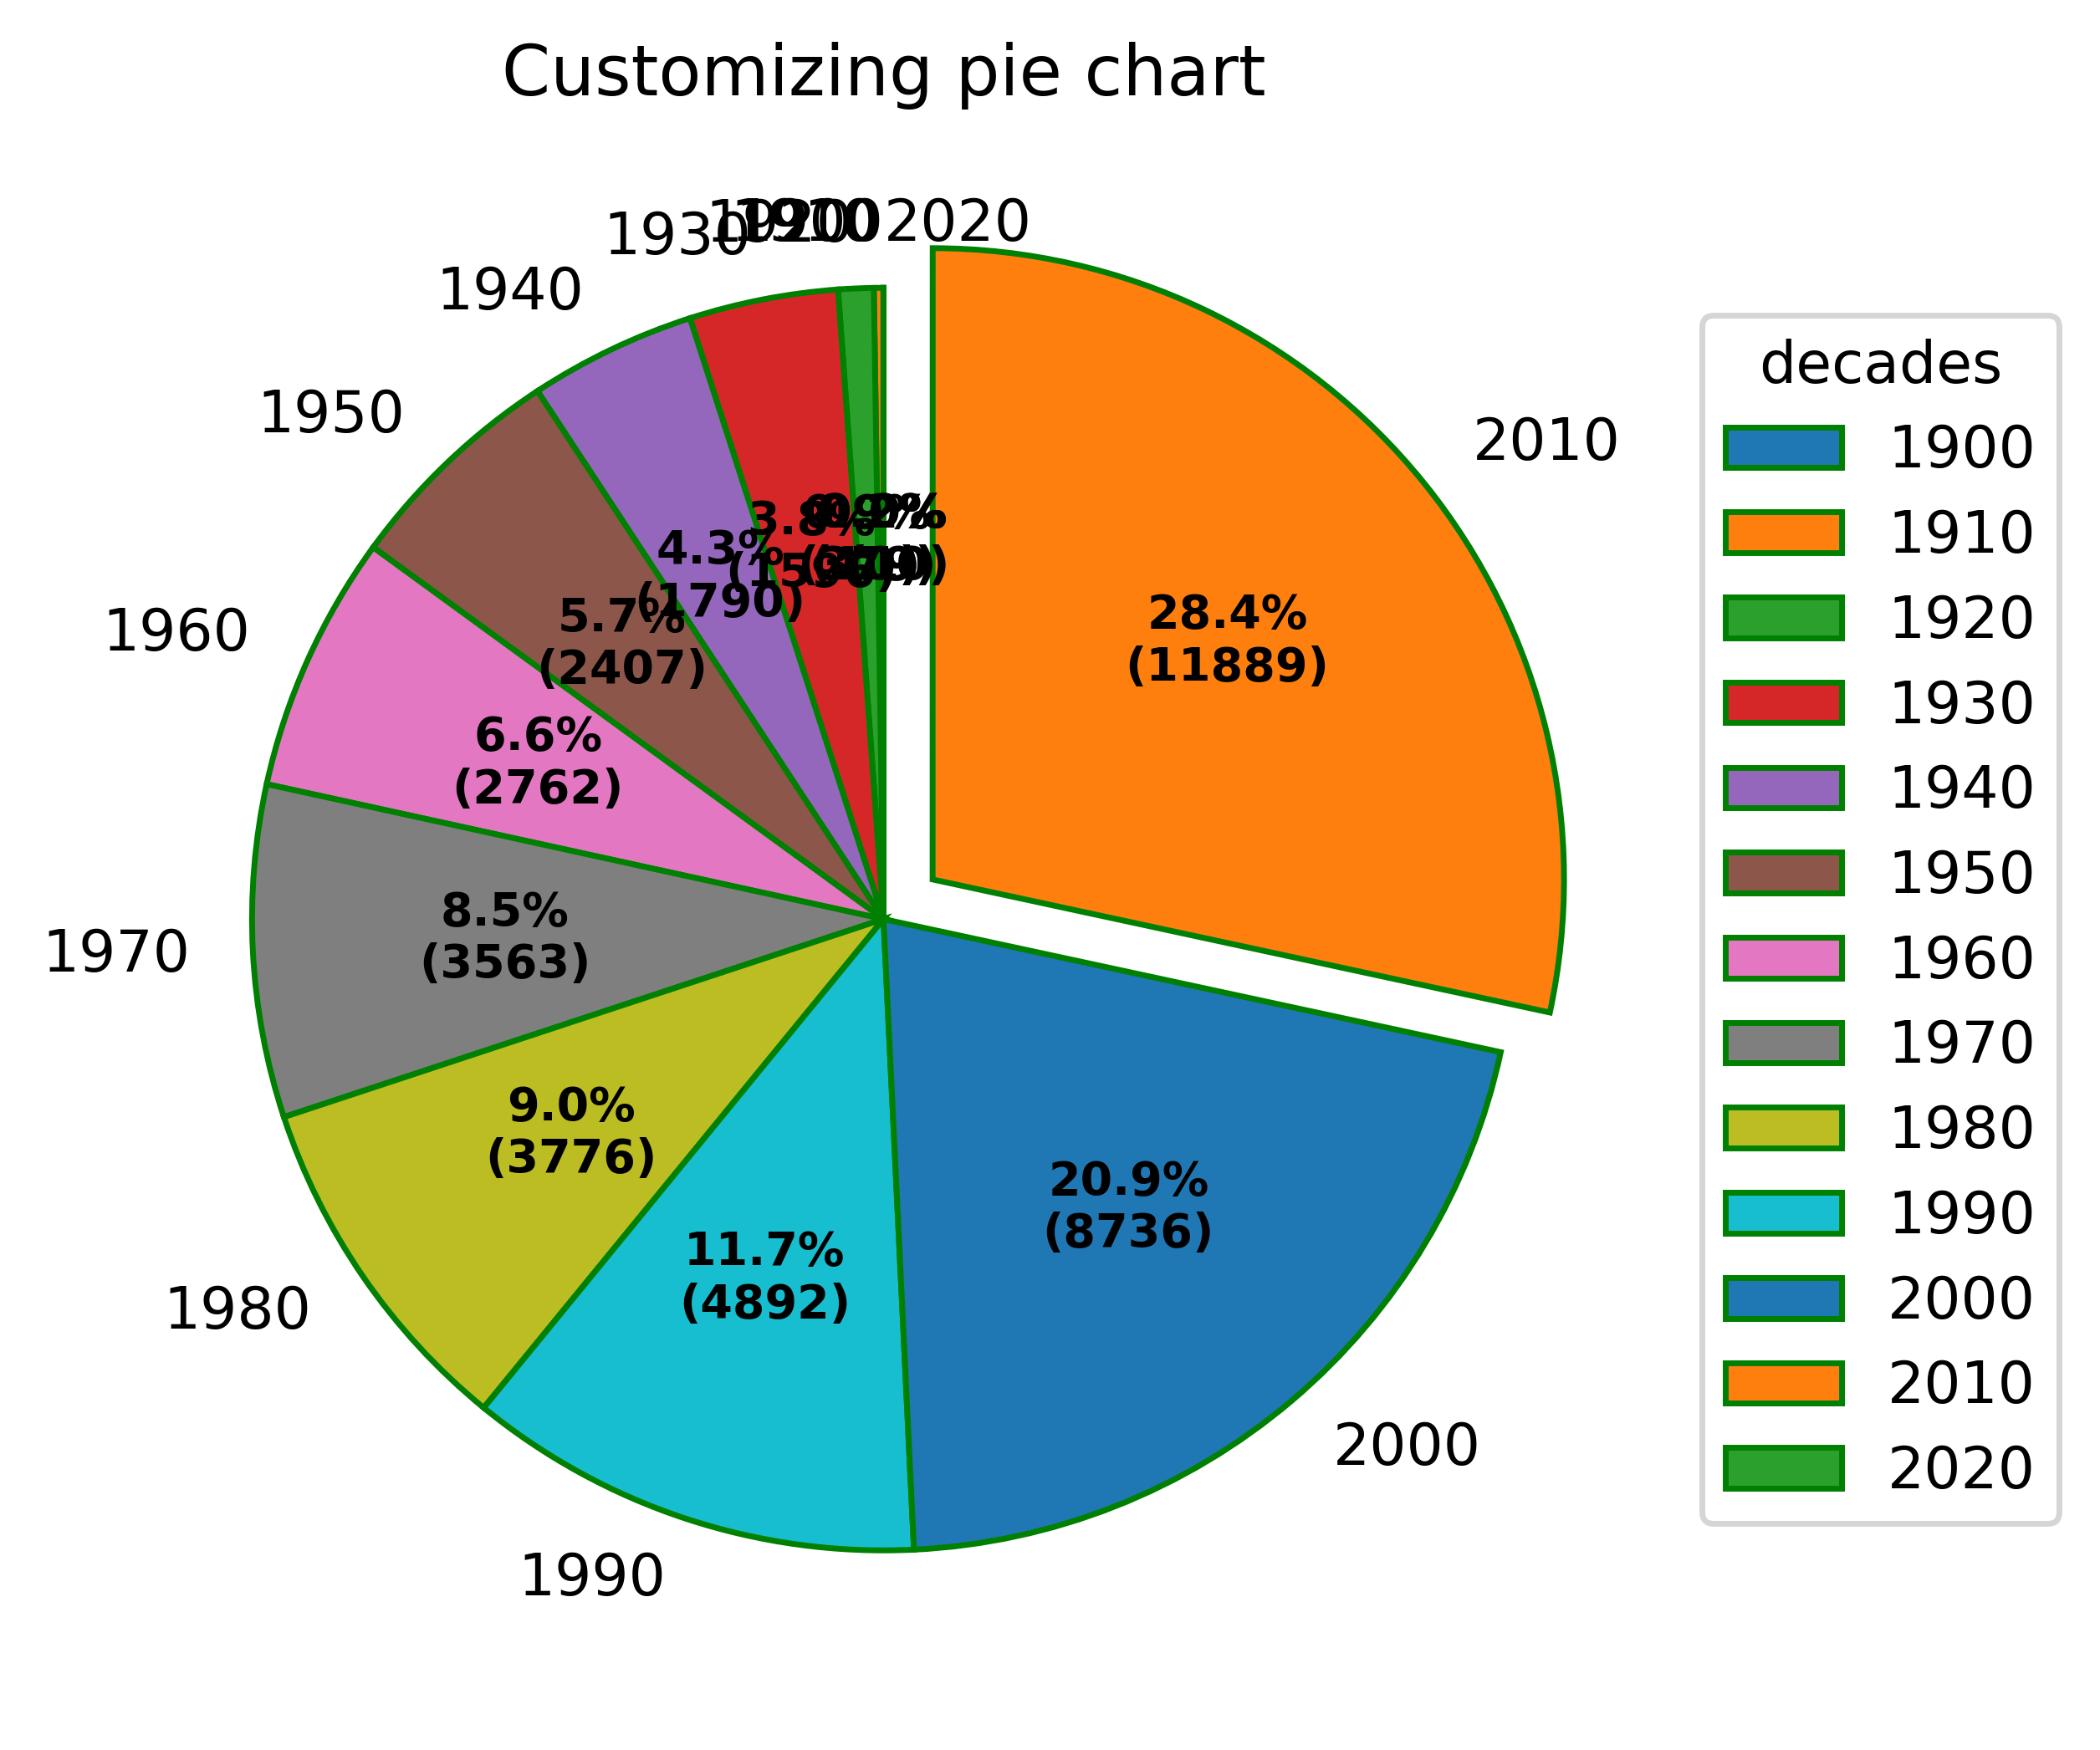

In [7]:
explode = (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1, 0)

def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

fig, ax = plt.subplots(figsize =(8,5), dpi=500)

wedges, texts, autotexts = ax.pie(x,
                                  autopct = lambda pct: func(pct, x),
                                  explode = explode,
                                  labels = x.index,
#                                   shadow = True,
                                  startangle = 90,
                                  wedgeprops = { 'linewidth' : 1, 'edgecolor' : "green" }
                                  # textprops = dict(color ="magenta")
                                 )


ax.legend(wedges, x.index,
          title ="decades",
          loc ="center left",
          bbox_to_anchor =(1, 0, 0.5, 1))

plt.setp(autotexts, size = 8, weight ="bold")
ax.set_title("Customizing pie chart")


plt.show()

In [8]:
all_genres = []

for item in df['genres']:
    for subitem in item.split('|'):
        if (subitem not in all_genres):
            all_genres.append( subitem )
print( all_genres )

['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'Mystery', 'Sci-Fi', 'IMAX', 'Documentary', 'War', 'Musical', 'Western', 'Film-Noir', '(no genres listed)']


In [9]:
for i in all_genres:
    df[i] = False

for index, row in df.iterrows():
#     print( index, row['imdb_title_id'], row['genres'])
    for subitem in row['genres'].split('|'):
        df.loc[index, subitem] = True

Adventure :  3244
Animation :  1107
Children :  1648
Comedy :  13029
Fantasy :  1910
Romance :  6515
Drama :  20509
Action :  5921
Crime :  4391
Thriller :  7095
Horror :  4632
Mystery :  2311
Sci-Fi :  2586
IMAX :  167
Documentary :  104
War :  1487
Musical :  889
Western :  1143
Film-Noir :  352
(no genres listed) :  2146


<AxesSubplot:>

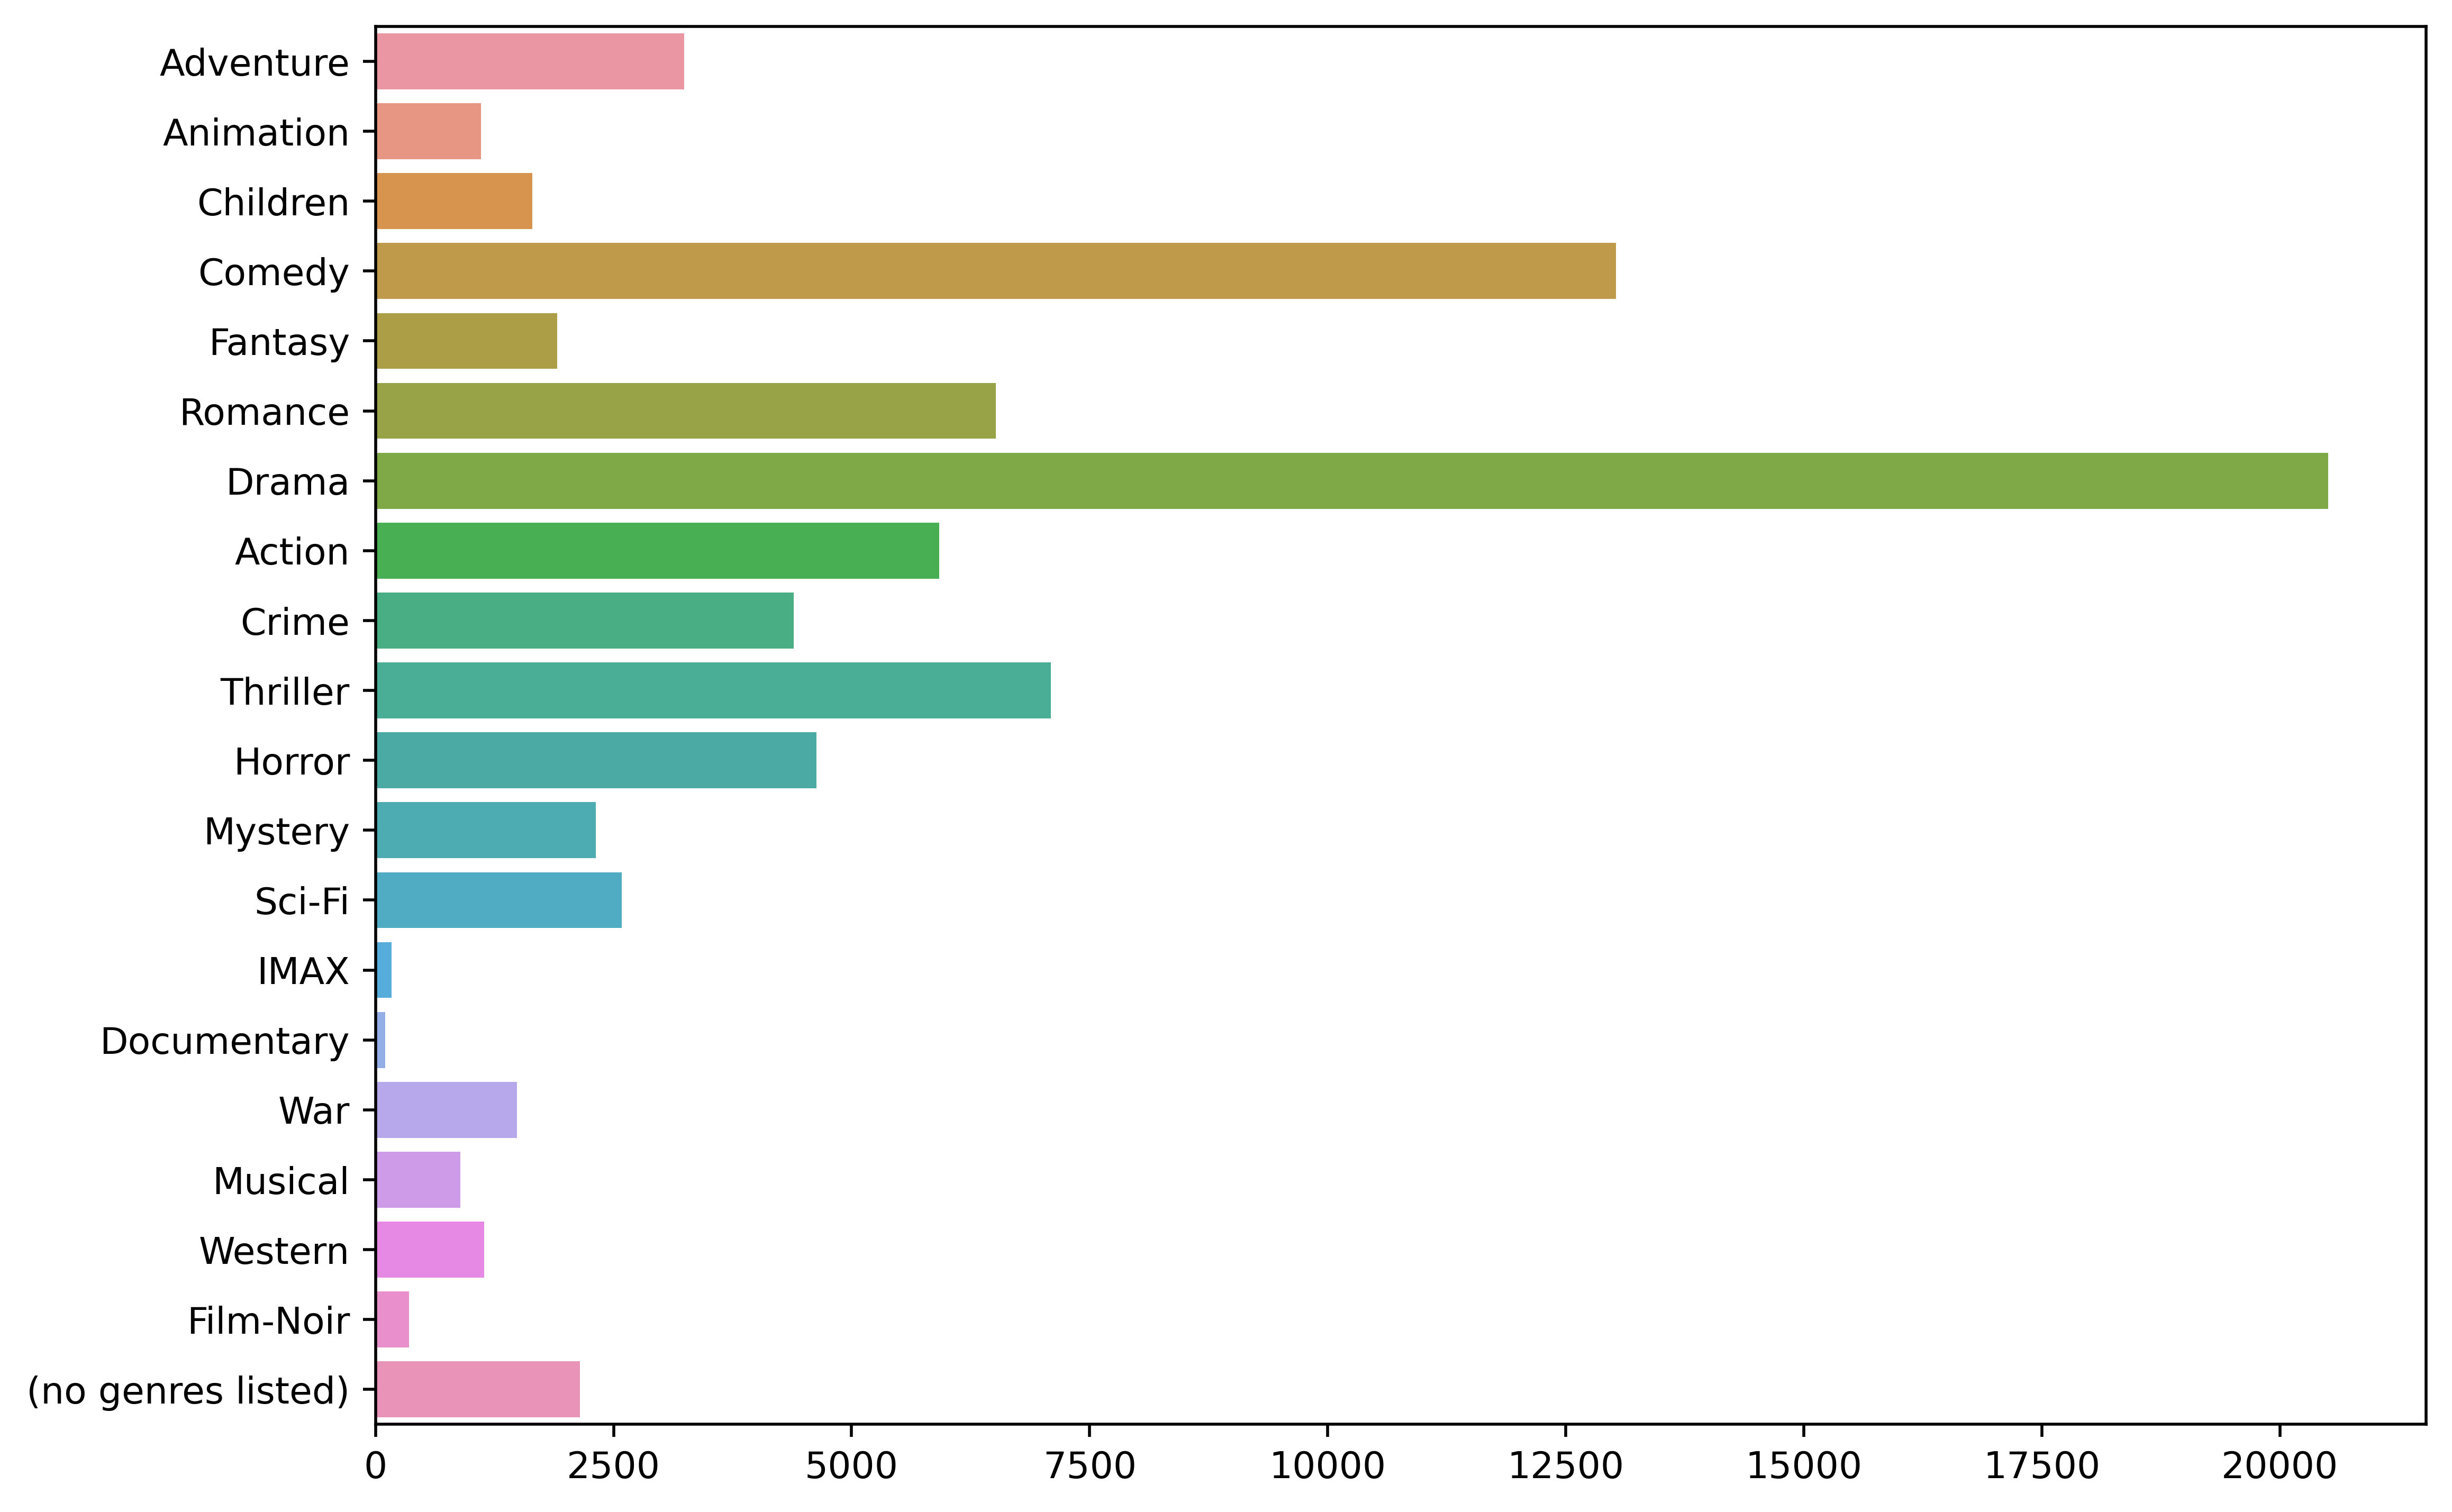

In [10]:
freq = {}

for item in df['genres']:
    for subitem in item.split('|'):
        if (subitem in freq):
            freq[subitem] += 1
        else:
            freq[subitem] = 1

for key, value in freq.items():
    print ("% s : % d"%(key, value))
    
plt.subplots(figsize =(10, 7), dpi=500)
# plt.barh(*zip(*freq.items()))
sns.barplot(y=list(freq.keys()), x=list(freq.values()), orient='h')

In [11]:
l = df.groupby((df.year//10)*10).sum()[ all_genres ]
l.head()

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
year,,,,,,,,,,,,,,,,,,,,
1900,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0
1910,11,0,3,22,11,16,67,5,7,2,6,3,1,0,0,8,0,6,0,11
1920,32,1,2,99,17,126,248,19,22,9,19,13,8,0,0,20,10,14,2,28
1930,122,6,22,564,37,536,833,81,210,93,60,141,31,0,2,65,114,80,13,97
1940,128,14,46,561,63,468,887,111,260,203,80,217,24,0,3,163,125,110,151,89


In [12]:
state_pcts = l.groupby(level=0).apply(lambda x: 100 * x / float(x.sum(axis=1)))
state_pcts.head()

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
year,,,,,,,,,,,,,,,,,,,,
1900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.333333,33.333333,33.333333,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1910,6.145251,0.000000,1.675978,12.290503,6.145251,8.938547,37.430168,2.793296,3.910615,1.117318,3.351955,1.675978,0.558659,0.0,0.000000,4.469274,0.000000,3.351955,0.000000,6.145251
1920,4.644412,0.145138,0.290276,14.368650,2.467344,18.287373,35.994194,2.757620,3.193033,1.306241,2.757620,1.886792,1.161103,0.0,0.000000,2.902758,1.451379,2.031930,0.290276,4.063861
1930,3.926617,0.193112,0.708079,18.152559,1.190859,17.251368,26.810428,2.607016,6.758931,2.993241,1.931123,4.538140,0.997747,0.0,0.064371,2.092050,3.669134,2.574831,0.418410,3.121983
1940,3.456657,0.378072,1.242236,15.149878,1.701323,12.638401,23.953551,2.997570,7.021334,5.482042,2.160410,5.860113,0.648123,0.0,0.081015,4.401836,3.375641,2.970564,4.077775,2.403457


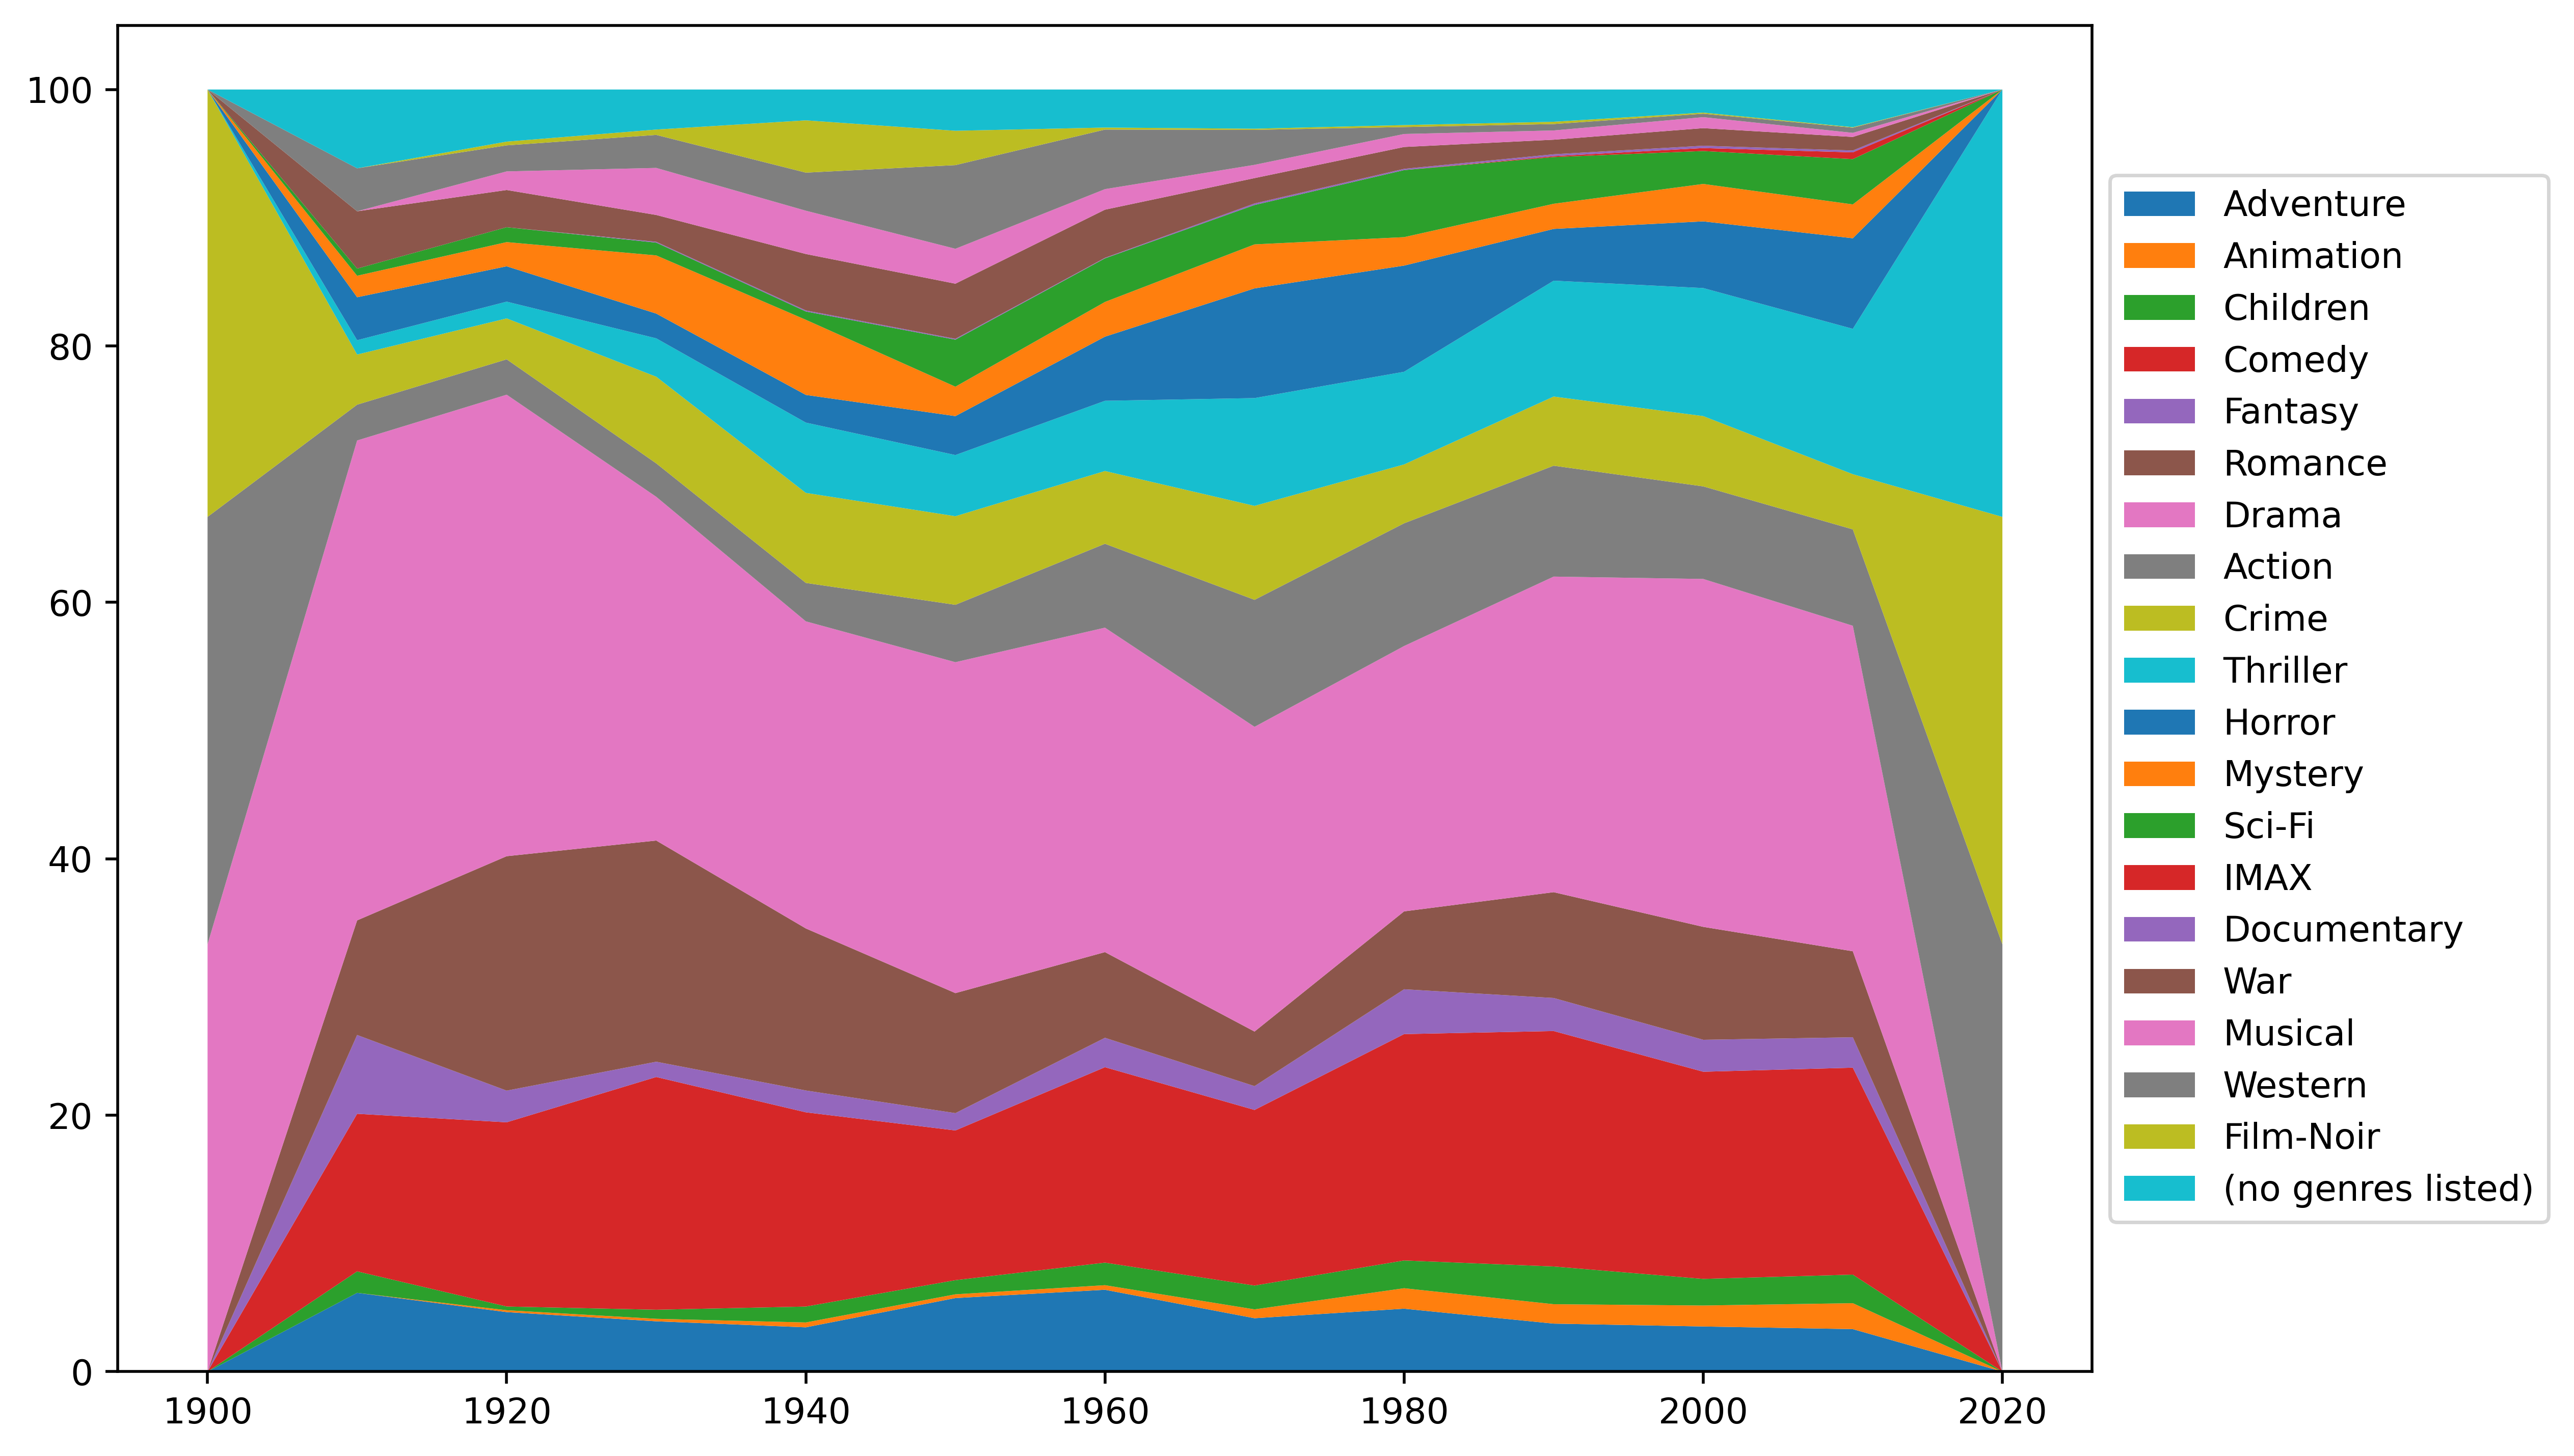

In [13]:
plt.subplots(figsize =(10, 7), dpi=500)

plt.stackplot(state_pcts.index, state_pcts.T ,labels=all_genres )

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

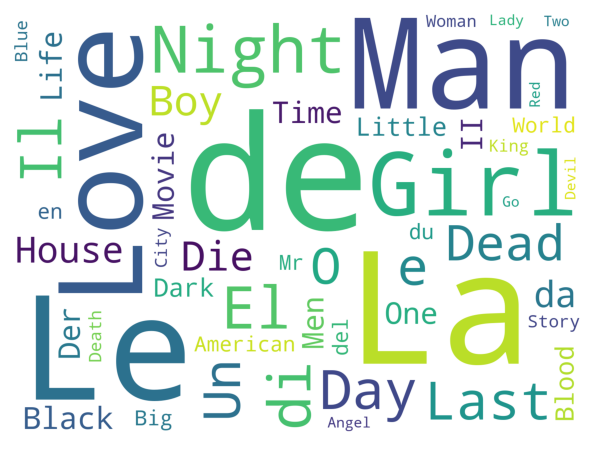

In [14]:
w=wc.WordCloud(background_color="white",margin=20,width=800,height=600,prefer_horizontal=0.7,max_words=50,scale=2)

w.generate(' '.join( df.original_title ))

f, ax = plt.subplots(figsize=(16, 8))
plt.axis('off')
plt.imshow(w)
plt.show()